# MSCA ML Final Project: Face-to-BMI
# Part 2: Image Embedding and Basic VGG

Deliverables:

1-You must create a simple web API to predict a user's BMI in real-time. You can also use webcam input. The goal is to use one of the pre-trained image models (e.g. VGG Face), fine-tune with the provided data, and deploy via jupyter notebook, streamlit, flask or any other simple restful api's.

2-10 pages of the write-up about your implementation.

3-10 mins presentation or live demo in the final lecture.

Our goal is to beat the performance metrics provided in the paper.

## Set-up

### Prepare basics

In [1]:
import os

# Google Bucket
bucket_path = 'gs://msca-sp23-bucket/ml_data'
file = 'BMI-20230313T174553Z-001.zip'
runtime_path = '/home/jupyter/data/ml/BMI'

os.chdir(runtime_path)
print(os.getcwd())

/home/jupyter/data/ml/BMI


In [2]:
import sys
import os
import pandas as pd
import numpy as np

import re
from tqdm import tqdm

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

In [4]:
# read csv file

bmi = pd.read_csv(runtime_path + '/all_data.csv')

bmi.head(2)

,bmi,gender,is_training,name,imgae_type,id,path
0,34.207396,Male,1,img_0.bmp,bmp,0,/home/jupyter/data/ml/BMI/Images/img_0.bmp
1,26.453720,Male,1,img_1.bmp,bmp,1,/home/jupyter/data/ml/BMI/Images/img_1.bmp


In [5]:
import tensorflow as tf
from tensorflow import keras

2023-05-20 22:15:09.049141: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-20 22:15:10.348780: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64::/opt/conda/lib
2023-05-20 22:15:10.348921: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_

In [6]:
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.11.0
Keras version: 2.11.0


In [7]:
# # @https://stackoverflow.com/questions/68862735/keras-vggface-no-module-named-keras-engine-topology
# ! pip install git+https://github.com/rcmalli/keras-vggface.git
# ! pip install keras_applications --no-deps

# #filename = "/opt/conda/envs/nlp/lib/python3.10/site-packages/keras_vggface/models.py" # for gcp_vs_code
# #filename = "/opt/conda/lib/python3.10/site-packages/keras_vggface/models.py" # for gcp jupyter login
# #filename = "/usr/local/lib/python3.10/dist-packages/keras_vggface/models.py" # for colab
# text = open(filename).read()
# open(filename, "w+").write(text.replace('keras.engine.topology', 'keras.utils.layer_utils'))

# ! pip install opencv-python
# ! pip install mtcnn
# filename = "/opt/conda/lib/python3.10/site-packages/mtcnn/mtcnn.py" # for gcp jupyter login
# text = open(filename).read()
# open(filename, "w+").write(text.replace('out = self._pnet.predict(img_y)', 'out = self._pnet.predict(img_y, verbose=0)'))
# open(filename, "w+").write(text.replace('out = self._rnet.predict(img_y)', 'out = self._rnet.predict(tempimg1, verbose=0)'))
# open(filename, "w+").write(text.replace('out = self._onet.predict(img_y)', 'out = self._onet.predict(tempimg1, verbose=0)'))

## Training

### Data split

In [8]:
df = bmi[['bmi', 'gender', 'is_training', 'path', 'name']] #.sample(800)
df.head()

,bmi,gender,is_training,path,name
0,34.207396,Male,1,/home/jupyter/data/ml/BMI/Images/img_0.bmp,img_0.bmp
1,26.453720,Male,1,/home/jupyter/data/ml/BMI/Images/img_1.bmp,img_1.bmp
2,34.967561,Female,1,/home/jupyter/data/ml/BMI/Images/img_2.bmp,img_2.bmp
3,22.044766,Female,1,/home/jupyter/data/ml/BMI/Images/img_3.bmp,img_3.bmp
4,25.845588,Female,1,/home/jupyter/data/ml/BMI/Images/img_6.bmp,img_6.bmp


In [9]:
# set configs
all_images_path = os.listdir('/home/jupyter/data/ml/BMI/') # for gcp

# split train, test; note that test set is not used for traning
train_set = df[df.is_training==1]
test_set = df[df.is_training==0] 

### Generating Data

#### Image Data Generator

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

mean_pixel_value = 110.0

img_dir = '/home/jupyter/data/ml/BMI/Images'


# Create the ImageDataGenerator for the train_data
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    #preprocessing_function=lambda x: (x - mean_pixel_value) / 255.0,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    validation_split=0.2
)

# Create the ImageDataGenerator for the test_data
test_datagen = ImageDataGenerator(
    #preprocessing_function=lambda x: (x - mean_pixel_value) / 255.0,
    rescale = 1./255
)

image_width, image_height = 224, 224
batch_size = 32

# Load the train data with target data
train_set_gen = train_datagen.flow_from_dataframe(
    train_set,
    directory= img_dir,
    x_col='name',
    y_col='bmi',
    target_size=(image_width, image_height),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='raw',
    subset='training'
)

# Load the validation data with target data
validation_set_gen = train_datagen.flow_from_dataframe(
    train_set,
    directory= img_dir,
    x_col='name',
    y_col='bmi',
    target_size=(image_width, image_height),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='raw',
    subset='validation'
)

# Load the test data with target data
test_set_gen = test_datagen.flow_from_dataframe(
    test_set,
    directory= img_dir,
    x_col='name',
    y_col='bmi',
    target_size=(image_width, image_height),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='raw'
)

Found 2568 validated image filenames.
Found 642 validated image filenames.
Found 753 validated image filenames.


#### Get generator for 'Extra_test_images'

In [11]:
# Filter a small subset of images from test
extra_images_df = bmi.head(10)
extra_images_paths = extra_images_df['path'].tolist()

path = '/home/jupyter/data/ml/BMI/Extra_test_images/'

extra_images_df['path'] = extra_images_df['name'].apply(lambda x: path+x)

/tmp/ipykernel_7604/1865940775.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extra_images_df['path'] = extra_images_df['name'].apply(lambda x: path+x)


In [12]:
# Load the test data with target data
extra_test_set_gen = test_datagen.flow_from_dataframe(
    extra_images_df,
    #directory='/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Extra_test_images', # colab
    directory = '/home/jupyter/data/ml/BMI/Extra_test_images',
    x_col='name',
    y_col='bmi',
    target_size=(image_width, image_height),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='raw'
)

Found 10 validated image filenames.


In [13]:
extra_images_df.head(5)

,bmi,gender,is_training,name,imgae_type,id,path
0,34.207396,Male,1,img_0.bmp,bmp,0,/home/jupyter/data/ml/BMI/Extra_test_images/img_0.bmp
1,26.453720,Male,1,img_1.bmp,bmp,1,/home/jupyter/data/ml/BMI/Extra_test_images/img_1.bmp
2,34.967561,Female,1,img_2.bmp,bmp,2,/home/jupyter/data/ml/BMI/Extra_test_images/img_2.bmp
3,22.044766,Female,1,img_3.bmp,bmp,3,/home/jupyter/data/ml/BMI/Extra_test_images/img_3.bmp
4,25.845588,Female,1,img_6.bmp,bmp,6,/home/jupyter/data/ml/BMI/Extra_test_images/img_6.bmp


### Train Model

In [14]:
from models_conv import *

/opt/conda/lib/python3.10/site-packages/mtcnn/mtcnn.py:206: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'Min':


In [15]:
mode = 'train' #'train' or 'predict'
model_type = 'vgg16'
model_tag = 'base'
model_id = '{:s}_{:s}'.format(model_type, model_tag)

bs = 8
epochs = 20
freeze_backbone = True # True => transfer learning; False => train from scratch

In [16]:
%%time

model = FacePrediction(img_dir = all_images_path, model_type = model_type)
model.define_model(freeze_backbone = freeze_backbone)
model.model.summary()

2023-05-20 22:15:12.288194: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64::/opt/conda/lib
2023-05-20 22:15:12.288237: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0   

### Load Model

In [17]:
from tensorflow.keras.models import load_model

#model_path = '/content/drive/MyDrive/Colab Datasets/ML/BMI/saved_models/saved_model_small_sample_vgg16_base.h5'
# gcp
model_path = '/home/jupyter/dl_image_bmi/saved_models/0520_saved_model_full_sample_uniPredict_vgg16_base_extra_cov_layer.h5'
#model_path = '/home/jupyter/dl_image_bmi/saved_models/0520_saved_model_full_sample_uniPredict_vgg16_base_no_layer.h5'

# use our own load model function
model.load_weights(model_path)

## Evaluations

In [18]:
y_test = test_set_gen.labels

In [19]:
%%time
model_preds = model.predict(img_dir, test_set_gen, show_img=False)

/home/jupyter/dl_image_bmi/models_conv.py:402: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = self.model.predict_generator(input_generator)


CPU times: user 11min, sys: 14.5 s, total: 11min 14s
Wall time: 43.4 s


In [20]:
rmse(y_test, model_preds) 
# 32.433900777299876
# 28.xxx
# 36.0457
# 15.271164972603007 for saved_model_small_sample_vgg16_base_extra_zero
# 14 for full sample no layer

12.225073245636938

In [21]:
mae(y_test, model_preds)

9.629689771077363

## Prediction

In [22]:
# import urllib.request

# # Download the Haar Cascade classifier file
# url = 'https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt.xml'
# file_name = 'haarcascade_frontalface_alt.xml'
# urllib.request.urlretrieve(url, file_name)

In [23]:
# def video_bmi(mod):
#     # Load the Haar Cascade classifier for face detection
#     face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')

#     cap = cv2.VideoCapture(0)

#     while True:
#         # Capture a frame from the video stream
#         ret, frame = cap.read()

#         # Convert the frame to grayscale for face detection
#         gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

#         # Detect faces in the grayscale frame
#         faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

#         # Iterate over the detected faces
#         for (x, y, w, h) in faces:
#             # Draw bounding boxes around the faces
#             cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
# And this will add them to the frame

/home/jupyter/dl_image_bmi/models_conv.py:430: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = self.model.predict_generator(single_test_gen)


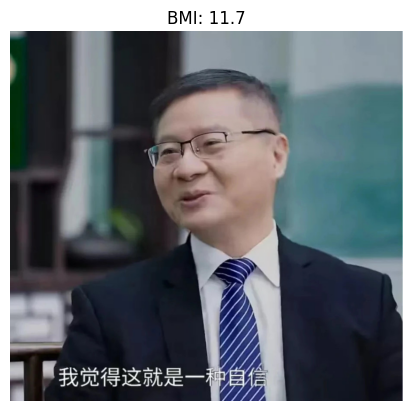

/home/jupyter/dl_image_bmi/models_conv.py:434: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = self.model.predict_generator(single_test_gen)


array([[18.337889]], dtype=float32)

In [24]:
#single_test_img = '/home/jupyter/data/ml/BMI/mannual_test/IMG_0654.bmp'
#single_test_img = '/home/jupyter/data/ml/BMI/mannual_test/IMG_8955.JPG'
single_test_img = '/home/jupyter/data/ml/BMI/mannual_test/IMG_5556.JPG'
model.predict(single_test_img, show_img=True)

Face 1: Confidence - 0.9999926090240479


/home/jupyter/dl_image_bmi/models_conv.py:349: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = self.model.predict_generator(single_test_gen)


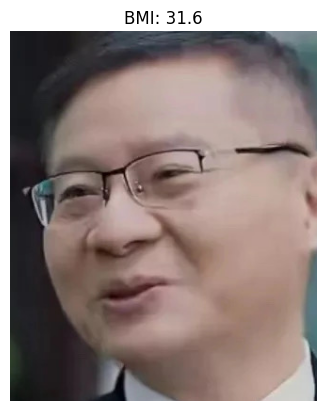

/home/jupyter/dl_image_bmi/models_conv.py:353: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = self.model.predict_generator(single_test_gen)


array([[30.98251]], dtype=float32)

In [25]:
model.predict_external(single_test_img, show_img=True)

/home/jupyter/dl_image_bmi/models_conv.py:402: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = self.model.predict_generator(input_generator)


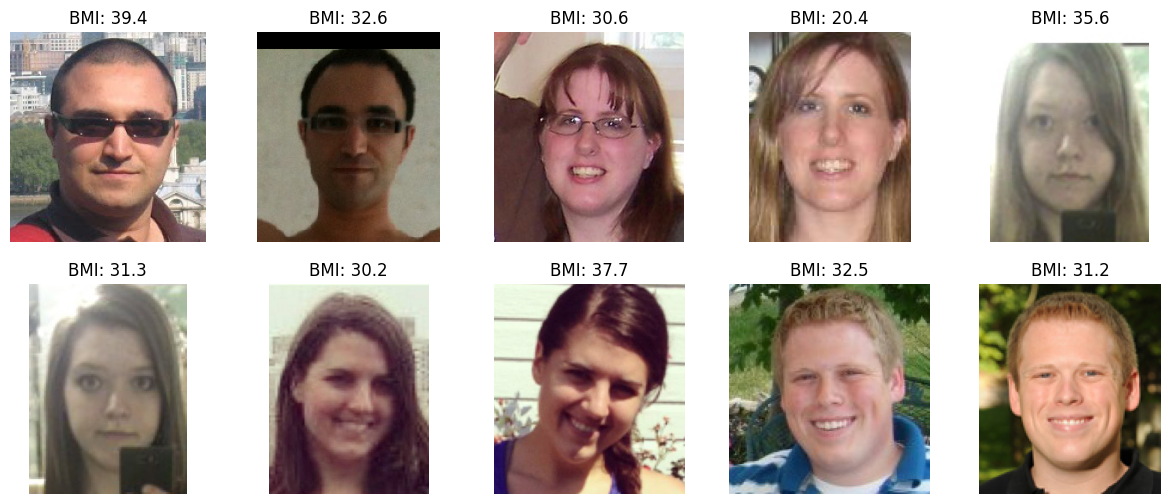

In [26]:
# Call the predict function
#img_dir = '/content/drive/MyDrive/Colab Datasets/ML/BMI/Data/Extra_test_images'
extra_test_dir = '/home/jupyter/data/ml/BMI/Extra_test_images'

show_img = True
predictions = model.predict(img_input_dir=extra_test_dir, input_generator=extra_test_set_gen, input_df=extra_images_df, show_img=show_img)

Face 1: Confidence - 0.9999997615814209
Face 1: Confidence - 0.9999993443489075
Face 1: Confidence - 0.9997241497039795
Face 1: Confidence - 0.9994588494300842
Face 1: Confidence - 0.999842643737793
Face 1: Confidence - 0.999679446220398
Face 1: Confidence - 0.9999791383743286
Face 1: Confidence - 0.9998461008071899
Face 1: Confidence - 0.999976396560669
Face 1: Confidence - 0.9999837875366211
Found 10 validated image filenames.


/home/jupyter/dl_image_bmi/models_conv.py:367: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['processed_paths'], test_df['processed_names'] = processed_img_paths, processed_img_names
/home/jupyter/dl_image_bmi/models_conv.py:367: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['processed_paths'], test_df['processed_names'] = processed_img_paths, processed_img_names
/home/jupyter/dl_image_bmi/models_conv.py:380: UserWarning: `Model.predict_generator` is deprecated and will be removed in a futur

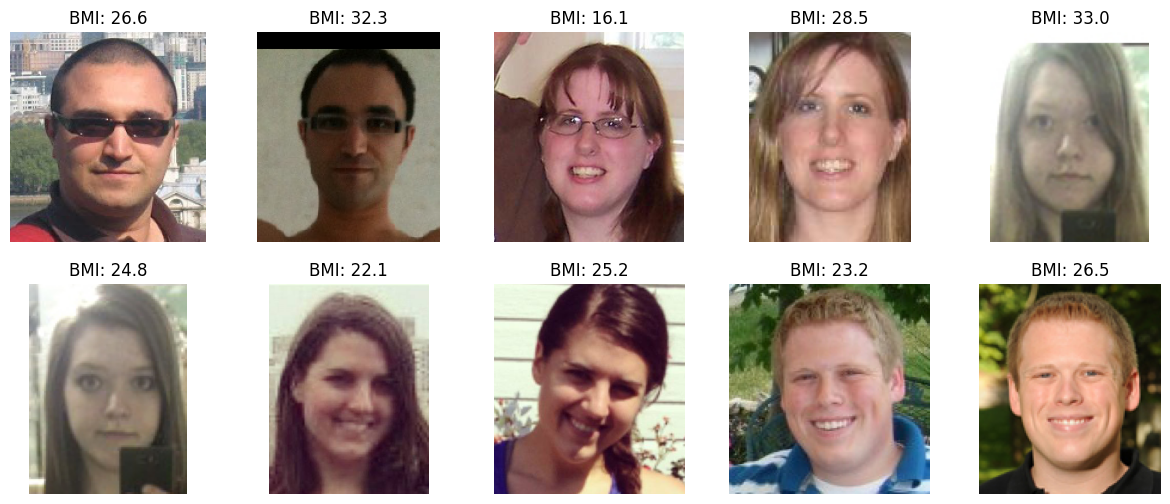

In [27]:
predictions = model.predict_external_dir(img_dir, 
                                     input_df=extra_images_df, show_img=show_img)

We see that when using group prediction, the performance is better when using `model.predict` instead of the user-defined-function `model.predict_external_dir` (function used to make group prediction).

One rationale is that the former function use `datagen.from_dataframe` and the latter use `datagen.from_flow` and a for-loop to read image data. Despite of using same preprocessing parameters, the input seems to be different because the results still differ.

For our web application, we will use the the prediction function for single input